WinPercentage
Team ID: ATL, Year: 9, Win Percentage: 11.76%
Team ID: ATL, Year: 10, Win Percentage: 52.94%
Team ID: CHA, Year: 1, Win Percentage: 25.00%
Team ID: CHA, Year: 2, Win Percentage: 56.25%
Team ID: CHA, Year: 3, Win Percentage: 56.25%
Team ID: CHA, Year: 4, Win Percentage: 52.94%
Team ID: CHA, Year: 5, Win Percentage: 47.06%
Team ID: CHA, Year: 6, Win Percentage: 17.65%
Team ID: CHA, Year: 7, Win Percentage: 32.35%
Team ID: CHI, Year: 7, Win Percentage: 14.71%
Team ID: CHI, Year: 8, Win Percentage: 41.18%
Team ID: CHI, Year: 9, Win Percentage: 35.29%
Team ID: CHI, Year: 10, Win Percentage: 47.06%
Team ID: CLE, Year: 1, Win Percentage: 53.12%
Team ID: CLE, Year: 2, Win Percentage: 68.75%
Team ID: CLE, Year: 3, Win Percentage: 31.25%
Team ID: CLE, Year: 4, Win Percentage: 50.00%
Team ID: CON, Year: 4, Win Percentage: 52.94%
Team ID: CON, Year: 5, Win Percentage: 52.94%
Team ID: CON, Year: 6, Win Percentage: 76.47%
Team ID: CON, Year: 7, Win Percentage: 76.47%
Team ID: CON, Year

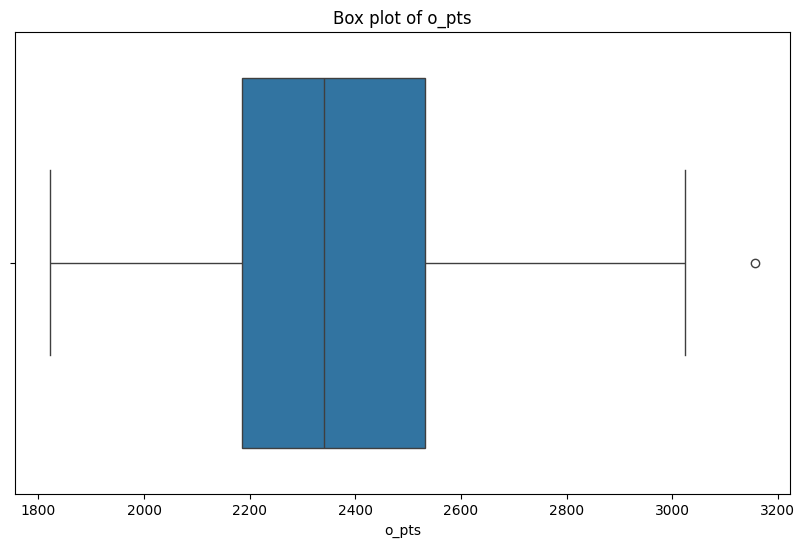

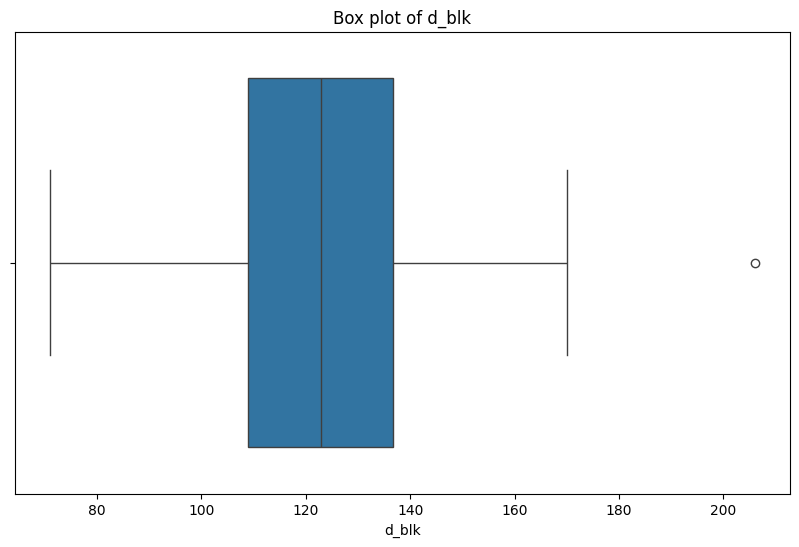

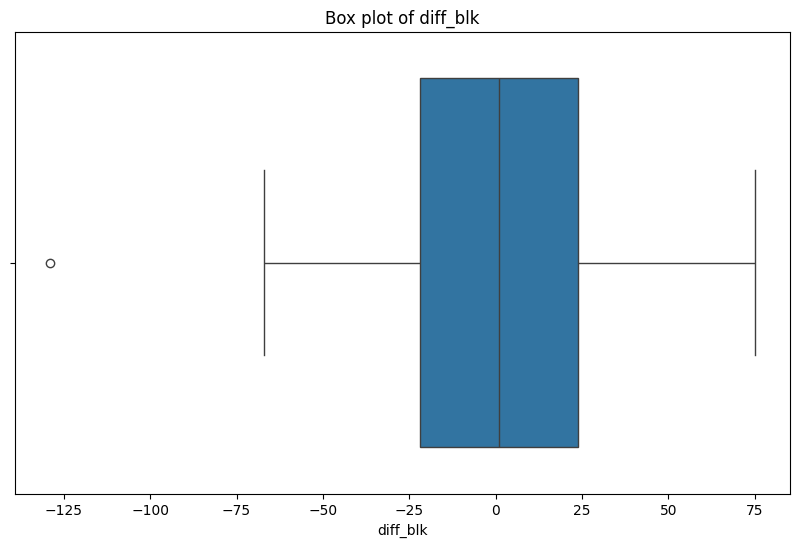

mean_diff_reb      0.363968
mean_diff_awayW    0.353762
mean_diff_dreb     0.343081
mean_diff_won      0.338469
diff_reb           0.337612
                     ...   
diff_tmDRB              NaN
diff_tmTRB              NaN
mean_diff_tmORB         NaN
mean_diff_tmDRB         NaN
mean_diff_tmTRB         NaN
Name: next_year_playoff, Length: 96, dtype: float64
Correlation With WinPercentage
0.2959574446046357
Best Accuracy: 0.72 with Logistic Regression using top 5 features
Selected features: ['mean_diff_dreb' 'mean_diff_reb' 'mean_diff_won' 'mean_diff_awayW'
 'mean_diff_confW']


In [2]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from sklearn.feature_selection import SelectKBest, f_classif



warnings.filterwarnings("ignore")





# Load all CSV files
awards_players = pd.read_csv("basketballPlayoffs/awards_players.csv")
coaches = pd.read_csv("basketballPlayoffs/coaches.csv")
players = pd.read_csv("basketballPlayoffs/players.csv")
players_teams = pd.read_csv("basketballPlayoffs/players_teams.csv")
series_post = pd.read_csv("basketballPlayoffs/series_post.csv")
teams = pd.read_csv("basketballPlayoffs/teams.csv")
teams_post = pd.read_csv("basketballPlayoffs/teams_post.csv")


# merge awards_players, players, players_teams and coaches on 
# players_awards and coaches_awards


players_awards = pd.merge(players_teams, awards_players, on=['playerID', 'year'], how='left')
players_awards = pd.merge(players_awards, players, left_on='playerID', right_on='bioID', how='left')
players_awards = players_awards.drop(columns=['bioID'])

# Convert birthDate to datetime
players_awards['birthDate'] = pd.to_datetime(players_awards['birthDate'])

# Calculate age
current_date = datetime.now()
players_awards['age'] = players_awards['birthDate'].apply(lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day)))

# Drop the birthDate column if no longer needed
players_awards.drop(columns=['birthDate'], inplace=True)


coaches_awards = pd.merge(coaches, awards_players, left_on=['coachID', 'year'], right_on=['playerID', 'year'], how='left')
coaches_awards = coaches_awards.drop(columns=['playerID'])





players_awards.to_csv('novos/players_awards.csv', index=False)
coaches_awards.to_csv('novos/coaches_awards.csv', index=False)





# Merge the two DataFrames on "year" and "tmID"
teams = pd.merge(teams, teams_post[['year', 'tmID', 'W', 'L']], on=['year', 'tmID'], how='left')

# Fill missing "W" and "L" values with 0
teams['W'] = teams['W'].fillna(0)
teams['L'] = teams['L'].fillna(0)


teams.to_csv('novos/teams.csv', index=False)


# return team with tmID and year
def get_team(tmID, year):
    return teams[(teams['tmID'] == tmID) & (teams['year'] == year)]


# make a script that for each team (year, tmID) search if the players of that team had any awards in the same year, if so add a column to the team dataframe with the number of awards
def add_awards_to_teams():
    teams['awards'] = 0
    for index, team in teams.iterrows():
        tmID = team['tmID']
        year = team['year']
        team_players = players_awards[(players_awards['tmID'] == tmID) & (players_awards['year'] == year)]
        awards = team_players['award'].count()
        teams.loc[index, 'awards'] = awards

        coaches_team = coaches_awards[(coaches_awards['tmID'] == tmID) & (coaches_awards['year'] == year)]
        awards = coaches_team['award'].count()
        teams.loc[index, 'awards'] += awards

        #if (coaches_team['award'] == 'Coach of the Year').any():
            #teams.loc[index, 'awards'] += 50


    teams.to_csv('novos/teams.csv', index=False)


add_awards_to_teams()



# Convert "playoff" feature to numeric (assuming "Y" for yes and "N" for no)
teams['playoff'] = teams['playoff'].apply(lambda x: 1 if x == 'Y' else 0)








teams['diff_fgm'] = teams['o_fgm'] - teams['d_fgm']
teams['diff_fga'] = teams['o_fga'] - teams['d_fga']

teams['diff_ftm'] = teams['o_ftm'] - teams['d_ftm']
teams['diff_fta'] = teams['o_fta'] - teams['d_fta']

teams['diff_3pm'] = teams['o_3pm'] - teams['d_3pm']
teams['diff_3pa'] = teams['o_3pa'] - teams['d_3pa']

teams['diff_oreb'] = teams['o_oreb'] - teams['d_oreb']
teams['diff_dreb'] = teams['o_dreb'] - teams['d_dreb']

teams['diff_reb'] = teams['o_reb'] - teams['d_reb']
teams['diff_asts'] = teams['o_asts'] - teams['d_asts']

teams['diff_pf'] = teams['o_pf'] - teams['d_pf']
teams['diff_stl'] = teams['o_stl'] - teams['d_stl']

teams['diff_to'] = teams['o_to'] - teams['d_to']
teams['diff_blk'] = teams['o_blk'] - teams['d_blk']

teams['diff_pts'] = teams['o_pts'] - teams['d_pts']
teams['diff_tmORB'] = teams['tmORB'] - teams['opptmORB']

teams['diff_tmDRB'] = teams['tmDRB'] - teams['opptmDRB']
teams['diff_tmTRB'] = teams['tmTRB'] - teams['opptmTRB']

teams['diff_won'] = teams['won'] - teams['lost']


teams['diff_homeW'] = teams['homeW'] - teams['homeL']
teams['diff_awayW'] = teams['awayW'] - teams['awayL']

teams['diff_confW'] = teams['confW'] - teams['confL']
teams['diff_W'] = teams['W'] - teams['L']


yearly_stats = {}

for year, year_data in teams.groupby('year'):
  
    year_dict = {}

    for index, row in year_data.iterrows():
        # offensive stats
        offensiveFieldGoalPercentage = (row['o_fgm'] / row['o_fga']) * 100

        # Update max and min for each stat per year
        year_dict.setdefault('offensiveFieldGoalPercentage', {'max': -float('inf'), 'min': float('inf')})
        year_dict['offensiveFieldGoalPercentage']['max'] = max(year_dict['offensiveFieldGoalPercentage']['max'], offensiveFieldGoalPercentage)
        year_dict['offensiveFieldGoalPercentage']['min'] = min(year_dict['offensiveFieldGoalPercentage']['min'], offensiveFieldGoalPercentage)

        offensiveFreeThrowPercentage = (row['o_ftm'] / row['o_fta']) * 100

        year_dict.setdefault('offensiveFreeThrowPercentage', {'max': -float('inf'), 'min': float('inf')})
        year_dict['offensiveFreeThrowPercentage']['max'] = max(year_dict['offensiveFreeThrowPercentage']['max'], offensiveFreeThrowPercentage)
        year_dict['offensiveFreeThrowPercentage']['min'] = min(year_dict['offensiveFreeThrowPercentage']['min'], offensiveFreeThrowPercentage)


        offensiveThreePointPercentage = (row['o_3pm'] / row['o_3pa']) * 100

        year_dict.setdefault('offensiveThreePointPercentage', {'max': -float('inf'), 'min': float('inf')})
        year_dict['offensiveThreePointPercentage']['max'] = max(year_dict['offensiveThreePointPercentage']['max'], offensiveThreePointPercentage)
        year_dict['offensiveThreePointPercentage']['min'] = min(year_dict['offensiveThreePointPercentage']['min'], offensiveThreePointPercentage)


        offensiveReboundsPerGame = row['o_reb'] / row['GP']

        year_dict.setdefault('offensiveReboundsPerGame', {'max': -float('inf'), 'min': float('inf')})
        year_dict['offensiveReboundsPerGame']['max'] = max(year_dict['offensiveReboundsPerGame']['max'], offensiveReboundsPerGame)
        year_dict['offensiveReboundsPerGame']['min'] = min(year_dict['offensiveReboundsPerGame']['min'], offensiveReboundsPerGame)


        offensiveAssistsPerGame = row['o_asts'] / row['GP']

        year_dict.setdefault('offensiveAssistsPerGame', {'max': -float('inf'), 'min': float('inf')})
        year_dict['offensiveAssistsPerGame']['max'] = max(year_dict['offensiveAssistsPerGame']['max'], offensiveAssistsPerGame)
        year_dict['offensiveAssistsPerGame']['min'] = min(year_dict['offensiveAssistsPerGame']['min'], offensiveAssistsPerGame)

        offensivePersonalFoulsPerGame = row['o_pf'] / row['GP']

        year_dict.setdefault('offensivePersonalFoulsPerGame', {'max': -float('inf'), 'min': float('inf')})
        year_dict['offensivePersonalFoulsPerGame']['max'] = max(year_dict['offensivePersonalFoulsPerGame']['max'], offensivePersonalFoulsPerGame)
        year_dict['offensivePersonalFoulsPerGame']['min'] = min(year_dict['offensivePersonalFoulsPerGame']['min'], offensivePersonalFoulsPerGame)

        offensiveStealsPerGame = row['o_stl'] / row['GP']

        year_dict.setdefault('offensiveStealsPerGame', {'max': -float('inf'), 'min': float('inf')})
        year_dict['offensiveStealsPerGame']['max'] = max(year_dict['offensiveStealsPerGame']['max'], offensiveStealsPerGame)
        year_dict['offensiveStealsPerGame']['min'] = min(year_dict['offensiveStealsPerGame']['min'], offensiveStealsPerGame)

        offensiveTurnoversPerGame = row['o_to'] / row['GP']

        year_dict.setdefault('offensiveTurnoversPerGame', {'max': -float('inf'), 'min': float('inf')})
        year_dict['offensiveTurnoversPerGame']['max'] = max(year_dict['offensiveTurnoversPerGame']['max'], offensiveTurnoversPerGame)
        year_dict['offensiveTurnoversPerGame']['min'] = min(year_dict['offensiveTurnoversPerGame']['min'], offensiveTurnoversPerGame)

        offensiveBlocksPerGame = row['o_blk'] / row['GP']

        year_dict.setdefault('offensiveBlocksPerGame', {'max': -float('inf'), 'min': float('inf')})
        year_dict['offensiveBlocksPerGame']['max'] = max(year_dict['offensiveBlocksPerGame']['max'], offensiveBlocksPerGame)
        year_dict['offensiveBlocksPerGame']['min'] = min(year_dict['offensiveBlocksPerGame']['min'], offensiveBlocksPerGame)

        offensivePointsPerGame = row['o_pts'] / row['GP']

        year_dict.setdefault('offensivePointsPerGame', {'max': -float('inf'), 'min': float('inf')})
        year_dict['offensivePointsPerGame']['max'] = max(year_dict['offensivePointsPerGame']['max'], offensivePointsPerGame)
        year_dict['offensivePointsPerGame']['min'] = min(year_dict['offensivePointsPerGame']['min'], offensivePointsPerGame)

        # defensive stats
        defensiveFieldGoalPercentage = (row['d_fgm'] / row['d_fga']) * 100

        year_dict.setdefault('defensiveFieldGoalPercentage', {'max': -float('inf'), 'min': float('inf')})
        year_dict['defensiveFieldGoalPercentage']['max'] = max(year_dict['defensiveFieldGoalPercentage']['max'], defensiveFieldGoalPercentage)
        year_dict['defensiveFieldGoalPercentage']['min'] = min(year_dict['defensiveFieldGoalPercentage']['min'], defensiveFieldGoalPercentage)

        defensiveFreeThrowPercentage = (row['d_ftm'] / row['d_fta']) * 100

        year_dict.setdefault('defensiveFreeThrowPercentage', {'max': -float('inf'), 'min': float('inf')})
        year_dict['defensiveFreeThrowPercentage']['max'] = max(year_dict['defensiveFreeThrowPercentage']['max'], defensiveFreeThrowPercentage)
        year_dict['defensiveFreeThrowPercentage']['min'] = min(year_dict['defensiveFreeThrowPercentage']['min'], defensiveFreeThrowPercentage)

        defensiveThreePointPercentage = (row['d_3pm'] / row['d_3pa']) * 100

        year_dict.setdefault('defensiveThreePointPercentage', {'max': -float('inf'), 'min': float('inf')})
        year_dict['defensiveThreePointPercentage']['max'] = max(year_dict['defensiveThreePointPercentage']['max'], defensiveThreePointPercentage)
        year_dict['defensiveThreePointPercentage']['min'] = min(year_dict['defensiveThreePointPercentage']['min'], defensiveThreePointPercentage)

        defensiveReboundsPerGame = row['d_reb'] / row['GP']

        year_dict.setdefault('defensiveReboundsPerGame', {'max': -float('inf'), 'min': float('inf')})
        year_dict['defensiveReboundsPerGame']['max'] = max(year_dict['defensiveReboundsPerGame']['max'], defensiveReboundsPerGame)
        year_dict['defensiveReboundsPerGame']['min'] = min(year_dict['defensiveReboundsPerGame']['min'], defensiveReboundsPerGame)

        defensiveAssistsPerGame = row['d_asts'] / row['GP']

        year_dict.setdefault('defensiveAssistsPerGame', {'max': -float('inf'), 'min': float('inf')})
        year_dict['defensiveAssistsPerGame']['max'] = max(year_dict['defensiveAssistsPerGame']['max'], defensiveAssistsPerGame)
        year_dict['defensiveAssistsPerGame']['min'] = min(year_dict['defensiveAssistsPerGame']['min'], defensiveAssistsPerGame)

        defensivePersonalFoulsPerGame = row['d_pf'] / row['GP']

        year_dict.setdefault('defensivePersonalFoulsPerGame', {'max': -float('inf'), 'min': float('inf')})
        year_dict['defensivePersonalFoulsPerGame']['max'] = max(year_dict['defensivePersonalFoulsPerGame']['max'], defensivePersonalFoulsPerGame)
        year_dict['defensivePersonalFoulsPerGame']['min'] = min(year_dict['defensivePersonalFoulsPerGame']['min'], defensivePersonalFoulsPerGame)

        defensiveStealsPerGame = row['d_stl'] / row['GP']

        year_dict.setdefault('defensiveStealsPerGame', {'max': -float('inf'), 'min': float('inf')})
        year_dict['defensiveStealsPerGame']['max'] = max(year_dict['defensiveStealsPerGame']['max'], defensiveStealsPerGame)
        year_dict['defensiveStealsPerGame']['min'] = min(year_dict['defensiveStealsPerGame']['min'], defensiveStealsPerGame)

        defensiveTurnoversPerGame = row['d_to'] / row['GP']

        year_dict.setdefault('defensiveTurnoversPerGame', {'max': -float('inf'), 'min': float('inf')})
        year_dict['defensiveTurnoversPerGame']['max'] = max(year_dict['defensiveTurnoversPerGame']['max'], defensiveTurnoversPerGame)
        year_dict['defensiveTurnoversPerGame']['min'] = min(year_dict['defensiveTurnoversPerGame']['min'], defensiveTurnoversPerGame)

        defensiveBlocksPerGame = row['d_blk'] / row['GP']

        year_dict.setdefault('defensiveBlocksPerGame', {'max': -float('inf'), 'min': float('inf')})
        year_dict['defensiveBlocksPerGame']['max'] = max(year_dict['defensiveBlocksPerGame']['max'], defensiveBlocksPerGame)
        year_dict['defensiveBlocksPerGame']['min'] = min(year_dict['defensiveBlocksPerGame']['min'], defensiveBlocksPerGame)

        defensivePointsPerGame = row['d_pts'] / row['GP']

        year_dict.setdefault('defensivePointsPerGame', {'max': -float('inf'), 'min': float('inf')})
        year_dict['defensivePointsPerGame']['max'] = max(year_dict['defensivePointsPerGame']['max'], defensivePointsPerGame)
        year_dict['defensivePointsPerGame']['min'] = min(year_dict['defensivePointsPerGame']['min'], defensivePointsPerGame)

        winPercentage = row['won'] / row['GP'] * 100

        year_dict.setdefault('winPercentage', {'max': -float('inf'), 'min': float('inf')})
        year_dict['winPercentage']['max'] = max(year_dict['winPercentage']['max'], winPercentage)
        year_dict['winPercentage']['min'] = min(year_dict['winPercentage']['min'], winPercentage)

        homeWinPercentage = row['homeW'] / (row['homeW'] + row['homeL']) * 100

        year_dict.setdefault('homeWinPercentage', {'max': -float('inf'), 'min': float('inf')})
        year_dict['homeWinPercentage']['max'] = max(year_dict['homeWinPercentage']['max'], homeWinPercentage)
        year_dict['homeWinPercentage']['min'] = min(year_dict['homeWinPercentage']['min'], homeWinPercentage)

        awayWinPercentage = row['awayW'] / (row['awayW'] + row['awayL']) * 100

        year_dict.setdefault('awayWinPercentage', {'max': -float('inf'), 'min': float('inf')})
        year_dict['awayWinPercentage']['max'] = max(year_dict['awayWinPercentage']['max'], awayWinPercentage)
        year_dict['awayWinPercentage']['min'] = min(year_dict['awayWinPercentage']['min'], awayWinPercentage)

        conferenceWinPercentage = row['confW'] / (row['confW'] + row['confL']) * 100

        year_dict.setdefault('conferenceWinPercentage', {'max': -float('inf'), 'min': float('inf')})
        year_dict['conferenceWinPercentage']['max'] = max(year_dict['conferenceWinPercentage']['max'], conferenceWinPercentage)
        year_dict['conferenceWinPercentage']['min'] = min(year_dict['conferenceWinPercentage']['min'], conferenceWinPercentage)

        attendance = row['attend']

        year_dict.setdefault('attendance', {'max': -float('inf'), 'min': float('inf')})
        year_dict['attendance']['max'] = max(year_dict['attendance']['max'], attendance)
        year_dict['attendance']['min'] = min(year_dict['attendance']['min'], attendance)

        rank = row['rank']

        year_dict.setdefault('rank', {'max': -float('inf'), 'min': float('inf')})
        year_dict['rank']['max'] = max(year_dict['rank']['max'], rank)
        year_dict['rank']['min'] = min(year_dict['rank']['min'], rank)

        o_oreb = row['o_oreb']

        year_dict.setdefault('o_oreb', {'max': -float('inf'), 'min': float('inf')})
        year_dict['o_oreb']['max'] = max(year_dict['o_oreb']['max'], o_oreb)
        year_dict['o_oreb']['min'] = min(year_dict['o_oreb']['min'], o_oreb)

        o_dreb = row['o_dreb']

        year_dict.setdefault('o_dreb', {'max': -float('inf'), 'min': float('inf')})
        year_dict['o_dreb']['max'] = max(year_dict['o_dreb']['max'], o_dreb)
        year_dict['o_dreb']['min'] = min(year_dict['o_dreb']['min'], o_dreb)

        d_oreb = row['d_oreb']

        year_dict.setdefault('d_oreb', {'max': -float('inf'), 'min': float('inf')})
        year_dict['d_oreb']['max'] = max(year_dict['d_oreb']['max'], d_oreb)
        year_dict['d_oreb']['min'] = min(year_dict['d_oreb']['min'], d_oreb)

        d_dreb = row['d_dreb']

        year_dict.setdefault('d_dreb', {'max': -float('inf'), 'min': float('inf')})
        year_dict['d_dreb']['max'] = max(year_dict['d_dreb']['max'], d_dreb)
        year_dict['d_dreb']['min'] = min(year_dict['d_dreb']['min'], d_dreb)

    yearly_stats[year] = year_dict






teams['winPercentage'] = teams['won'] / teams['GP'] * 100




print("WinPercentage")

for index, row in teams.iterrows():

    year = row['year']
    teams['winPercentage'] = teams['won'] / teams['GP'] * 100
    teams['winPercentage'] = (teams['winPercentage'] - yearly_stats[year]['winPercentage']['min']) / (
        yearly_stats[year]['winPercentage']['max'] - yearly_stats[year]['winPercentage']['min']) * 100






    print(f"Team ID: {row['tmID']}, Year: {row['year']}, Win Percentage: {row['winPercentage']:.2f}%")





# create new columns with mean of diff features from the current and the previsous year
def add_mean_diff_features(years=2):
    for index, team in teams.iterrows():
        tmID = team['tmID']
        year = team['year']
        diffs = {feature: [] for feature in ['diff_fgm', 'diff_fga', 'diff_ftm', 'diff_fta', 'diff_3pm', 'diff_3pa', 'diff_oreb', 'diff_dreb', 'diff_reb', 'diff_asts', 'diff_pf', 'diff_stl', 'diff_to', 'diff_blk', 'diff_pts', 'diff_tmORB', 'diff_tmDRB', 'diff_tmTRB', 'diff_won', 'diff_homeW', 'diff_awayW', 'diff_confW', 'diff_W']}
        
        for i in range(0, years):
            previous_year = year - i
            previous_team = get_team(tmID, previous_year)
            if not previous_team.empty:
                for feature in diffs.keys():
                    diffs[feature].append(previous_team[feature].values[0])
        
        for feature, values in diffs.items():
            if values:
                teams.loc[index, f'mean_{feature}'] = (team[feature] + sum(values)) / (len(values) + 1)
            else:
                teams.loc[index, f'mean_{feature}'] = team[feature]

# Example usage:
add_mean_diff_features(years=2)

# newly created features in a list
new_features = ['mean_diff_fgm', 'mean_diff_fga', 'mean_diff_ftm', 'mean_diff_fta', 'mean_diff_3pm', 'mean_diff_3pa', 'mean_diff_oreb', 'mean_diff_dreb', 'mean_diff_reb', 'mean_diff_asts', 'mean_diff_pf', 'mean_diff_stl', 'mean_diff_to', 'mean_diff_blk', 'mean_diff_pts', 'mean_diff_tmORB', 'mean_diff_tmDRB', 'mean_diff_tmTRB', 'mean_diff_won', 'mean_diff_homeW', 'mean_diff_awayW', 'mean_diff_confW', 'mean_diff_W']







# check correlation between features and playoff
features = ["o_fgm", "o_fga", "o_ftm", "o_fta", "o_3pm", "o_3pa", "o_oreb", "o_dreb", "o_reb", "o_asts", "o_pf", "o_stl", "o_to", "o_blk", "o_pts", "d_fgm", "d_fga", "d_ftm", "d_fta", "d_3pm", "d_3pa", "d_oreb", "d_dreb", "d_reb", "d_asts", "d_pf", "d_stl", "d_to", "d_blk", "d_pts", "tmORB", "tmDRB", "tmTRB", "opptmORB", "opptmDRB", "opptmTRB", "won", "lost", "GP", "homeW", "homeL", "awayW", "awayL", "confW", "confL", "min", "attend", "W", "L", "awards",'diff_fgm', 'diff_fga', 'diff_ftm', 'diff_fta', 'diff_3pm', 'diff_3pa', 'diff_oreb', 'diff_dreb', 'diff_reb', 'diff_asts', 'diff_pf', 'diff_stl', 'diff_to', 'diff_blk', 'diff_pts','diff_tmORB', 'diff_tmDRB', 'diff_tmTRB', 'diff_won', 'diff_homeW', 'diff_awayW', 'diff_confW']
features.extend(new_features)
features.extend(['winPercentage'])


original_features = ["o_fgm", "o_fga", "o_ftm", "o_fta", "o_3pm", "o_3pa", "o_oreb", "o_dreb", "o_reb", "o_asts", "o_pf", "o_stl", "o_to", "o_blk", "o_pts", "d_fgm", "d_fga", "d_ftm", "d_fta", "d_3pm", "d_3pa", "d_oreb", "d_dreb", "d_reb", "d_asts", "d_pf", "d_stl", "d_to", "d_blk", "d_pts", "tmORB", "tmDRB", "tmTRB", "opptmORB", "opptmDRB", "opptmTRB", "won", "lost", "GP", "homeW", "homeL", "awayW", "awayL", "confW", "confL", "min", "attend", "W", "L"]

# Function to detect outliers using Z-score
def detect_outliers_zscore(df, features, threshold=3):
    outliers = {}
    for feature in features:
        mean = np.mean(df[feature])
        std_dev = np.std(df[feature])
        z_scores = (df[feature] - mean) / std_dev
        outliers[feature] = df[np.abs(z_scores) > threshold]
    return outliers

# Detect outliers
outliers = detect_outliers_zscore(teams, original_features)

# Print outliers for each feature
for feature, outlier_df in outliers.items():
    if not outlier_df.empty:
        print(f"Outliers detected in feature '{feature}':")
        print(outlier_df[[feature]])
        print("\n")



# Plot box plots for the features with detected outliers
features_with_outliers = ['o_pts', 'd_blk', 'diff_blk']

for feature in features_with_outliers:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=teams[feature])
    plt.title(f'Box plot of {feature}')
    plt.show()







# Ensure the dataset is ordered by tmID and year
teams = teams.sort_values(by=['tmID', 'year'])


# Create a new column for next year's playoff status
teams['next_year_playoff'] = teams.groupby('tmID')['playoff'].shift(-1)

teams.to_csv('novos/teams.csv', index=False)

# Calculate the correlation matrix
correlation_matrix = teams[features + ['next_year_playoff']].corr()

# Extract the correlation of each feature with 'next_year_playoff'
correlation_with_target = correlation_matrix['next_year_playoff'].drop('next_year_playoff')

# Print the correlations
# ordered by the correlation value
correlation_with_target = correlation_with_target.sort_values(ascending=False)
print(correlation_with_target)

print("Correlation With WinPercentage")
print(correlation_with_target['winPercentage'])


# print to a csv for year 1 what teams made the playoffs in year 2
def print_playoffs(year):
    year_1_df = teams[teams['year'] == year]
    playoff_teams = year_1_df
    playoff_teams = playoff_teams[['tmID', 'year', 'playoff','diff_pts','next_year_playoff']]
    playoff_teams = playoff_teams.sort_values(by='diff_pts', ascending=False)
    playoff_teams.to_csv(f'winners/playoffs_{year}.csv', index=False)


print_playoffs(1)
print_playoffs(2)
print_playoffs(3)
print_playoffs(4)
print_playoffs(5)
print_playoffs(6)
print_playoffs(7)
print_playoffs(8)
print_playoffs(9)
print_playoffs(10)





#print p_point in teams per team and per year
def print_p_points(name, year):
    team = get_team(name, year)
    print(f'{name} in {year} has {team["o_pts"].values[0]} points')


#print_p_points('ATL', 10)

'''
correlation_matrix = teams[features + ['playoff']].corr()

correlation_with_target = correlation_matrix['playoff'].drop('playoff')

print(correlation_with_target)
'''




# try to train a model
# Split the data into training and testing sets based on year
df = teams[(teams['year'] <= 9) & (teams['year'] >= 3)]

df = df.dropna(subset=['next_year_playoff'])

# Split the data into features (X) and target (y)
X = df[features]
y = df['next_year_playoff']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a range of values for k (number of top features to select)
k_values = range(1, len(features) + 1)

# Define a list of models to try
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier()),
    ('Support Vector Machine', SVC())
]

# Initialize variables to keep track of the best accuracy, model, k, and features
best_accuracy = 0
best_model_name = ''
best_k = 0
best_features = []

# Loop through each model and each value of k
for model_name, model in models:
    for k in k_values:
        # Select the best features
        selector = SelectKBest(score_func=f_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        # Train the model
        model.fit(X_train_selected, y_train)
        predictions = model.predict(X_test_selected)
        accuracy = accuracy_score(y_test, predictions)
        #print(f'{model_name} Accuracy with top {k} features: {accuracy:.2f}')

        # Check if this is the best accuracy so far
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_name = model_name
            best_k = k
            best_features = np.array(features)[selector.get_support()]

# Print the best accuracy, model, k, and selected features
print(f'Best Accuracy: {best_accuracy:.2f} with {best_model_name} using top {best_k} features')
print(f'Selected features: {best_features}')




 





